In [24]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import librosa
from tqdm.notebook import tqdm
from IPython.display import Audio
from pandas.api.types import is_numeric_dtype


import sys
sys.path.append('../')
import default_style

TS_DATASET_FOLDER = os.path.join("..", "dataset")
TS_PREPROC_FOLDER = os.path.join(TS_DATASET_FOLDER, "preprocessed_traces")
DF_PREPROC_FILE = os.path.join(TS_PREPROC_FOLDER, "preproc_ts.df")

INTERESTING_TRACES = [ "syllables_fourier", "std_phon_trace", "traces_fourier", "spectral_centroid", "spectral_mode"]
INTERESTING_TRACES += [f"syllables_{i}_ts" for i in range(7)]

## Save folder for long-run estimators
ESTIMATORS_FOLDER = os.path.join("..", "estimators")
matplotlib.rcParams['figure.figsize'] = (10, 5)

## Import

In [2]:
df = pd.read_csv(DF_PREPROC_FILE)

traces = dict()
for t in INTERESTING_TRACES:
    traces[t] = np.load(os.path.join(TS_PREPROC_FOLDER, f"{t}.npy"), allow_pickle=True)

traces["syll_labels"] = np.repeat(np.arange(7), len(traces["syllables_fourier"])//7)
print(traces["syll_labels"].shape)

(7,)


## Metrics

In [60]:
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import cdist

In [61]:
mat_euclidean = cdist(traces["traces_fourier"],traces["traces_fourier"])

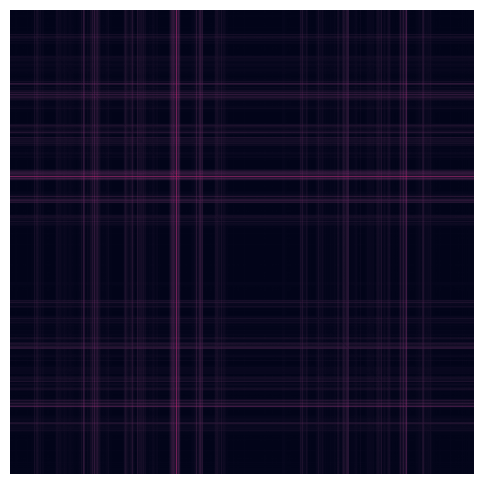

In [85]:
plt.grid("")
plt.axis("off")
plt.imshow(mat_euclidean)

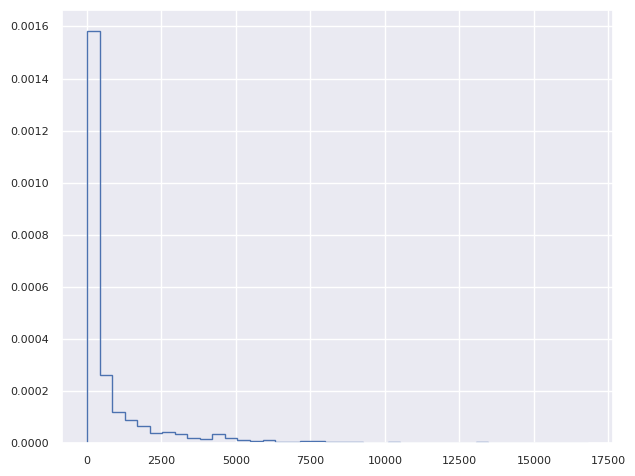

In [6]:
# Distribution of distances
distances_eucl = np.triu(mat_euclidean).reshape(-1)
distances_eucl = distances_eucl[distances_eucl != 0.0]
plt.hist(distances_eucl, histtype="step", bins=40, density=True);

### Manhattan

In [7]:
mat_manhattan = cdist(traces["traces_fourier"],traces["traces_fourier"], metric="cityblock")

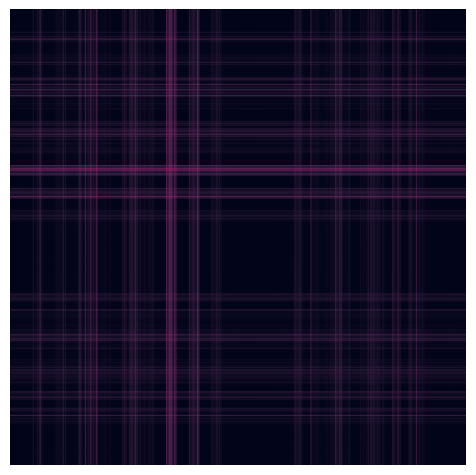

In [8]:
plt.grid("")
plt.axis("off")
plt.imshow(mat_manhattan)

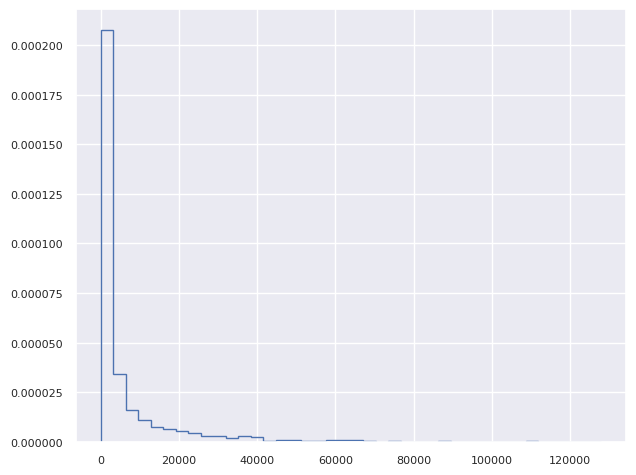

In [9]:
# Distribution of distances
distances_man = np.triu(mat_manhattan).reshape(-1)
distances_man = distances_man[distances_man != 0.0]
plt.hist(distances_man, histtype="step", bins=40, density=True);

### DTW

In [ ]:
from tslearn.metrics import cdist_dtw

mat_dtw = cdist_dtw(traces["std_phon_trace"][:10],traces["std_phon_trace"][:10], itakura_max_slope=2, n_jobs=-1)

In [ ]:
plt.grid("")
plt.axis("off")
plt.imshow(mat_dtw)

## Test: KNN search

In [6]:
from tslearn.neighbors import KNeighborsTimeSeries
from sklearn.model_selection import train_test_split

C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 1 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


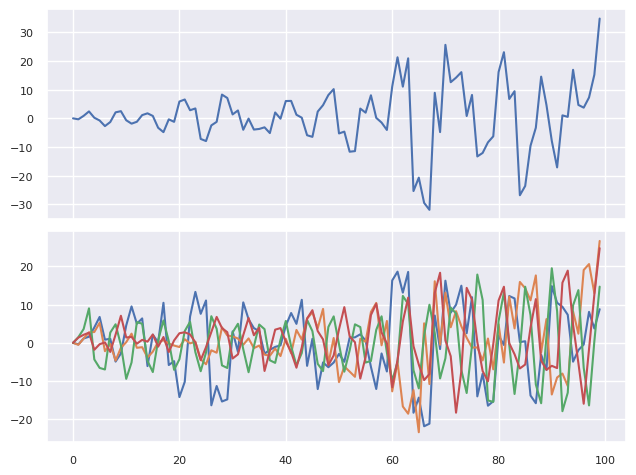

In [10]:
X_train, X_test = train_test_split(traces["traces_fourier"], test_size=0.1)

knn = KNeighborsTimeSeries(n_neighbors=4)
knn.fit(X_train)

# Find nearest neighbours of a query trace
query_trace = 1
nearest = knn.kneighbors([X_test[query_trace]], return_distance=False)[0]

fig, (axquery, axnearest) = plt.subplots(2,1, sharex=True)

# Plot the requested query
axquery.plot(X_test[query_trace])

# Plot the most similar results
for idx in nearest:
    axnearest.plot(X_train[idx])

In [ ]:
X_train.shape

## Kmeans

### Spectral timeseries (Euclidean)

In [174]:
from tslearn.clustering import TimeSeriesKMeans, silhouette_score, KernelKMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, adjusted_mutual_info_score as ami

In [268]:
X = np.stack(traces["spectral_centroid"])

C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 2452 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 2452 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 2452 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 2452 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX

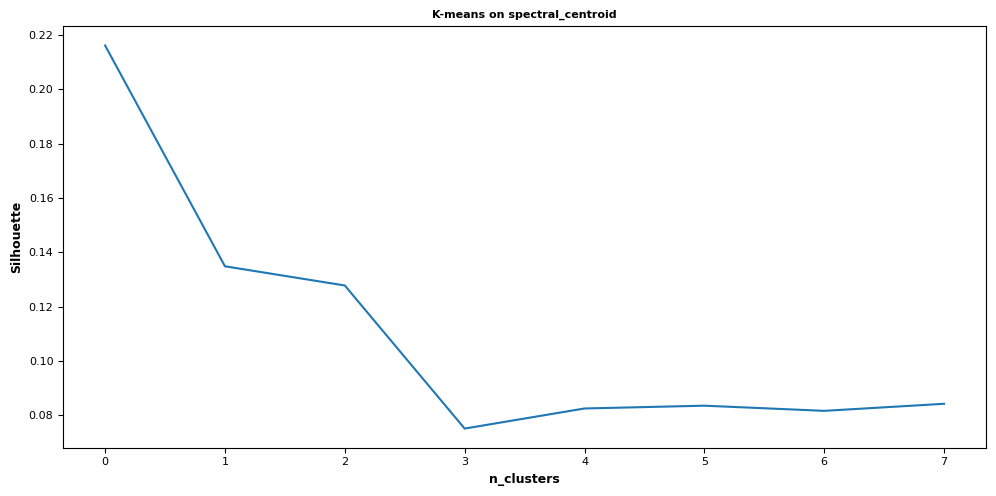

In [274]:
sil_scores = []
for n in range(2, 10):
    km = TimeSeriesKMeans(n_clusters=n, metric="euclidean", n_jobs=-1)
    km.fit(X)
    sil_scores.append(silhouette_score(X, km.predict(X), metric="euclidean", n_jobs=-1))
plt.plot(sil_scores)
plt.title('K-means on spectral_centroid')
plt.ylabel('Silhouette')
plt.xlabel('n_clusters')

plt.show()

1565
887


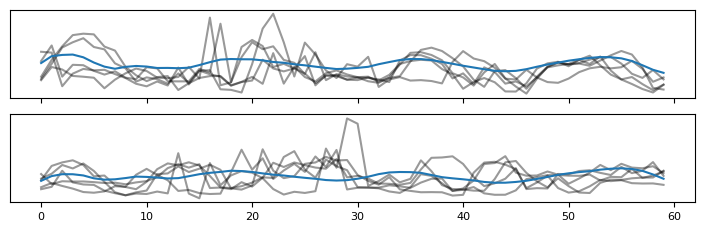

In [275]:
n_clusters = 2

km = TimeSeriesKMeans(n_clusters=n_clusters, verbose=False, n_jobs=-1)
km.fit_predict(X)

fig, axes = plt.subplots(n_clusters,1,sharex=True, figsize=default_style.SHORT_FULLSIZE_FIGURE)

for clus in range(n_clusters):
    cluster_elements = X[km.labels_ == clus]
    print(len(cluster_elements))
    for i in range(5):
        axes[clus].plot(cluster_elements[i], alpha=0.4, color="k")
    axes[clus].set_yticks([])
    axes[clus].plot(km.cluster_centers_[clus])
plt.savefig("../images/ts_classification.pdf")

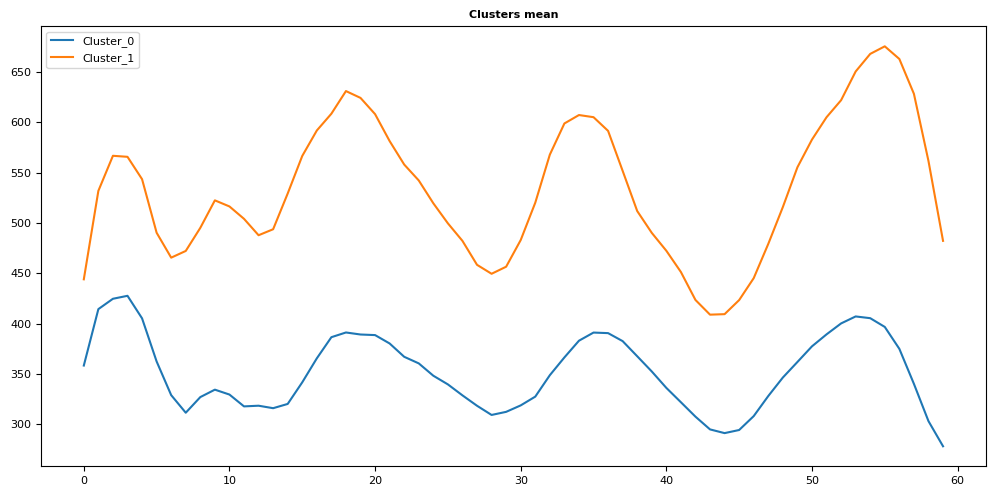

In [278]:
for i in range(n_clusters):
    plt.plot(np.mean(X[np.where(km.labels_ == i)[0]], axis=0), label=f'Cluster_{i}' )
plt.legend()
plt.title('Clusters mean traces')
plt.show()

In [279]:
df_ex = df.copy()
df_ex['km_clust'] = km.labels_

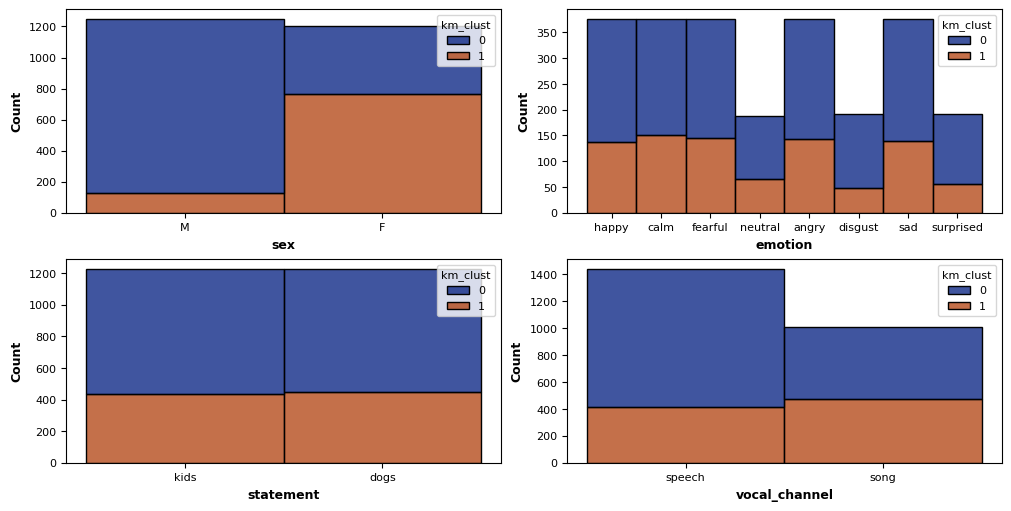

In [331]:
fig, axs = plt.subplots(nrows=2, ncols=2, constrained_layout=True)
i=0
j=0
for col in ['sex', 'emotion', 'statement', 'vocal_channel']:
        if j==2:
            j=0
            i=i+1
        sns.histplot(df_ex, x=col, hue='km_clust', multiple="stack" ,palette='dark', ax=axs[i][j])
        j=j+1
plt.show()

### Spectral timeseries (DTW)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 2452 out of 2452 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.2s
[Parallel(n_jobs=

845283.147 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 4904 out of 4904 | elapsed:    1.1s finished


565732.009 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 4904 out of 4904 | elapsed:    1.0s finished


561961.379 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 4904 out of 4904 | elapsed:    1.1s finished


561714.155 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 4904 out of 4904 | elapsed:    1.1s finished


561631.098 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 4904 out of 4904 | elapsed:    1.0s finished


561624.327 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 4904 out of 4904 | elapsed:    1.1s finished


561603.338 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 4904 out of 4904 | elapsed:    1.1s finished


561603.338 --> 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 4904 out of 4904 | elapsed:    1.1s finished


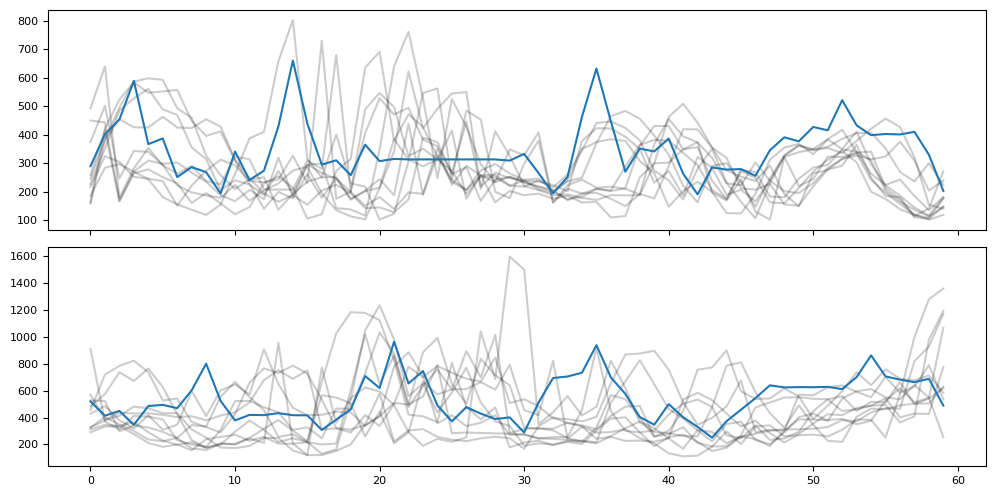

In [332]:
n_clusters = 2

# Fit and save
km = TimeSeriesKMeans(n_clusters=n_clusters,
                      metric="dtw",
                      n_jobs=-1,
                      verbose=True)

km.fit_predict(X)
# Save the estimator
km.to_pickle(os.path.join(ESTIMATORS_FOLDER, "dtw_kmeans"))

km = TimeSeriesKMeans.from_pickle(os.path.join(ESTIMATORS_FOLDER, "dtw_kmeans"))

fig, axes = plt.subplots(n_clusters,1,sharex=True)

for clus in range(n_clusters):
    cluster_elements = X[km.labels_ == clus]
    for i in range(10):
        axes[clus].plot(cluster_elements[i], alpha=0.2, color="k")
    axes[clus].plot(km.cluster_centers_[clus])

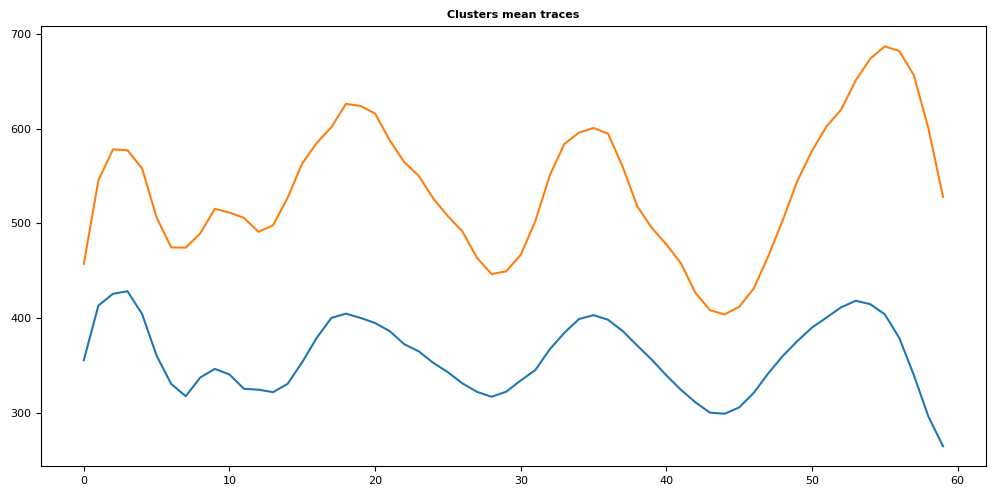

In [333]:
for i in range(n_clusters):
    plt.plot(np.mean(X[np.where(km.labels_ == i)[0]], axis=0))
    plt.title('Clusters mean traces')
plt.show()

In [334]:
df_ex = df.copy()
df_ex['km_clust'] = km.labels_

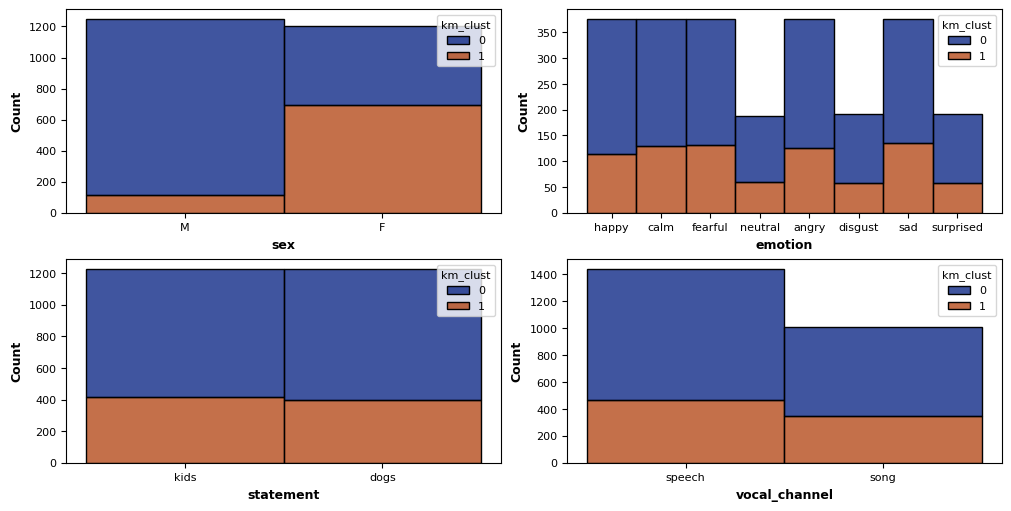

In [335]:
fig, axs = plt.subplots(nrows=2, ncols=2, constrained_layout=True)
i=0
j=0
for col in ['sex', 'emotion', 'statement', 'vocal_channel']:
        if j==2:
            j=0
            i=i+1
        sns.histplot(df_ex, x=col, hue='km_clust', multiple="stack" ,palette='dark', ax=axs[i][j])
        j=j+1
plt.show()

## Approximated Clustering std_phon

In [10]:
from pyts.approximation import DiscreteFourierTransform
from tslearn.piecewise import PiecewiseAggregateApproximation

In [428]:
X = np.stack(traces["std_phon_trace"])

n_paa_segments = 30
paa = PiecewiseAggregateApproximation(n_segments=n_paa_segments)
X_paa = paa.fit_transform(X)


C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 2452 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


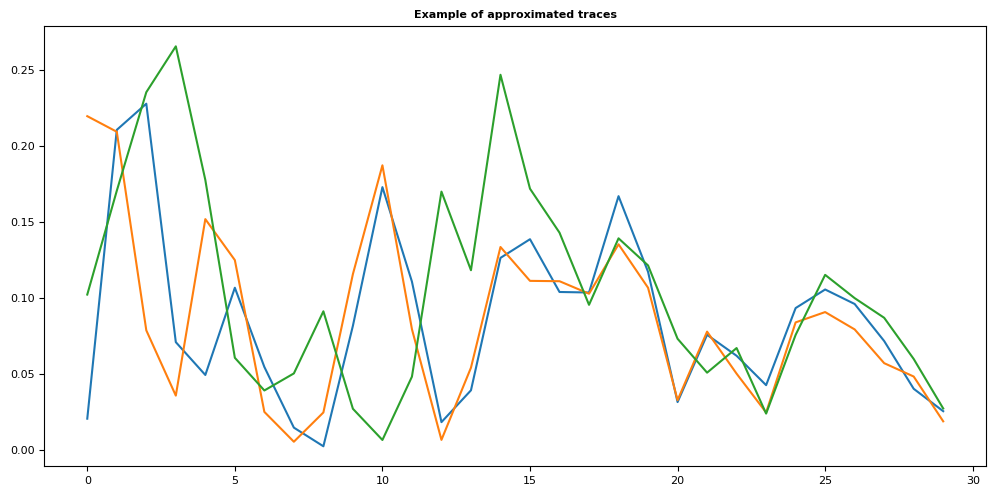

In [336]:
plt.plot(X_paa[0])
plt.plot(X_paa[1])
plt.plot(X_paa[2])
plt.title('Example of PAA traces ')
plt.show()

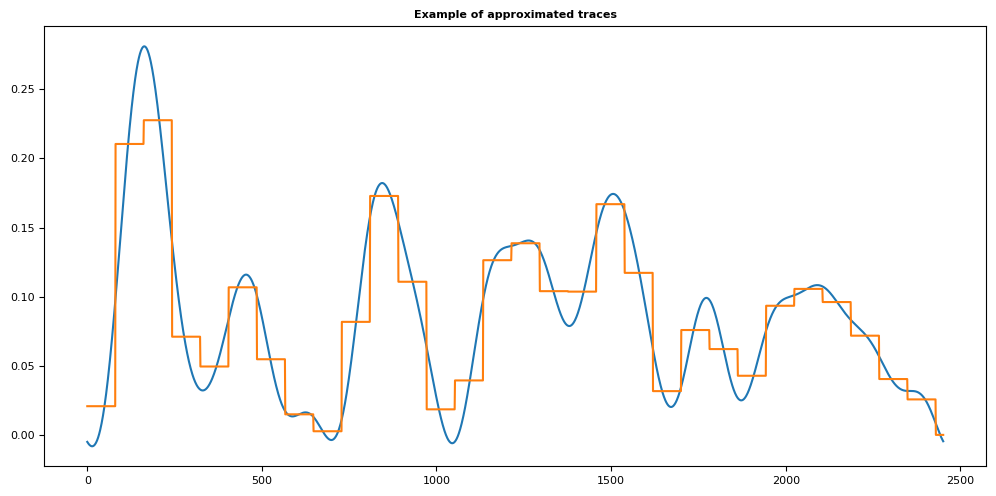

In [337]:
plt.plot(traces['std_phon_trace'][0])
plt.plot(paa.inverse_transform(X_paa)[0])
plt.title('Example of approximated traces')
plt.show()

In [ ]:
sil_scores = []
for n in range(2, 10):
    km = TimeSeriesKMeans(n_clusters=n, metric="euclidean")
    km.fit(X_paa)
    sil_scores.append(silhouette_score(X_paa, km.predict(X_paa), metric="euclidean"))
    

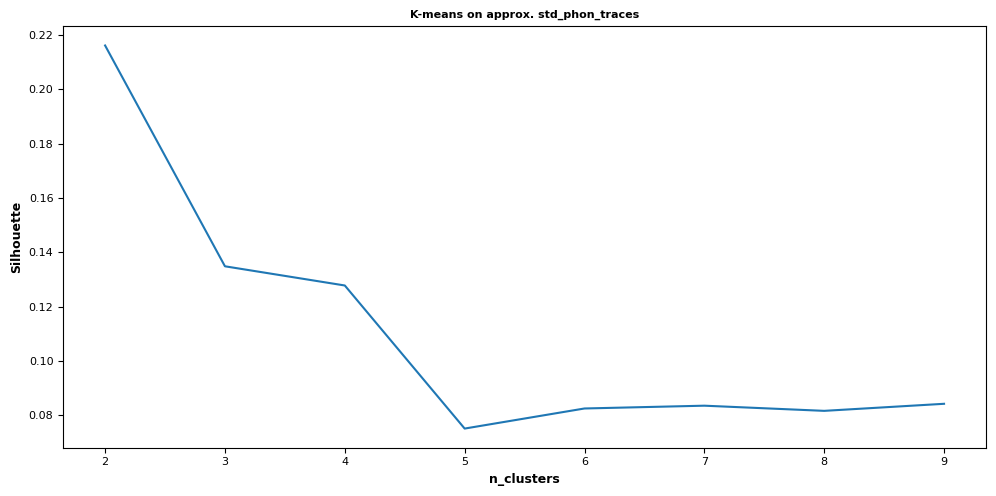

In [338]:
plt.plot(range(2, 10),sil_scores)
plt.title('K-means on approx. std_phon_traces')
plt.ylabel('Silhouette')
plt.xlabel('n_clusters')
plt.show()

0.204 --> 0.107 --> 0.105 --> 0.104 --> 0.103 --> 0.103 --> 0.103 --> 0.103 --> 0.103 --> 0.103 --> 0.103 --> 0.103 --> 0.103 --> 0.103 --> 0.103 --> 0.103 --> 0.103 --> 0.103 --> 0.103 --> 0.103 --> 


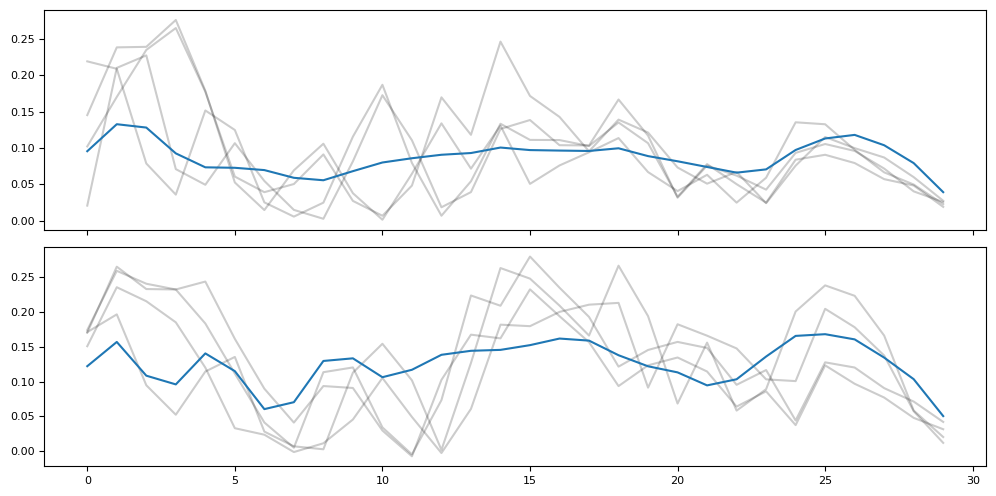

In [429]:
n_clusters = 2

# np.random.shuffle(X_train)
km = TimeSeriesKMeans(n_clusters=n_clusters, verbose=True, metric='euclidean', n_jobs=-1)#or dtw
km.fit_predict(X_paa)

fig, axes = plt.subplots(n_clusters,sharex=True)

for clus in range(n_clusters):
    cluster_elements = X_paa[km.labels_ == clus]
    for i in range(4):
        axes[clus].plot(cluster_elements[i], alpha=0.2, color="k")
    
    axes[clus].plot(km.cluster_centers_[clus])
plt.show()

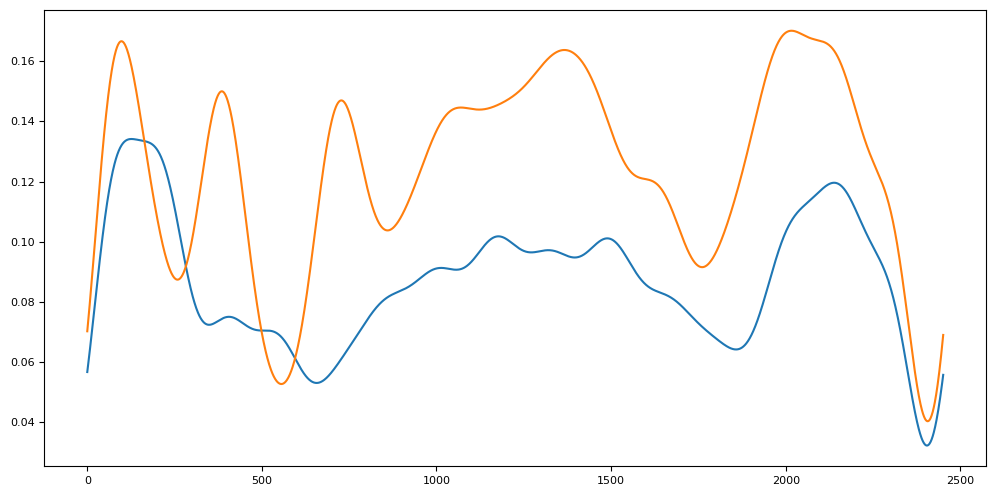

In [430]:
for i in range(n_clusters):
    plt.plot(np.mean(X[np.where(km.labels_ == i)[0]], axis=0))
plt.show()

In [431]:
df_ex = df.copy()
df_ex['km_clust'] = km.labels_

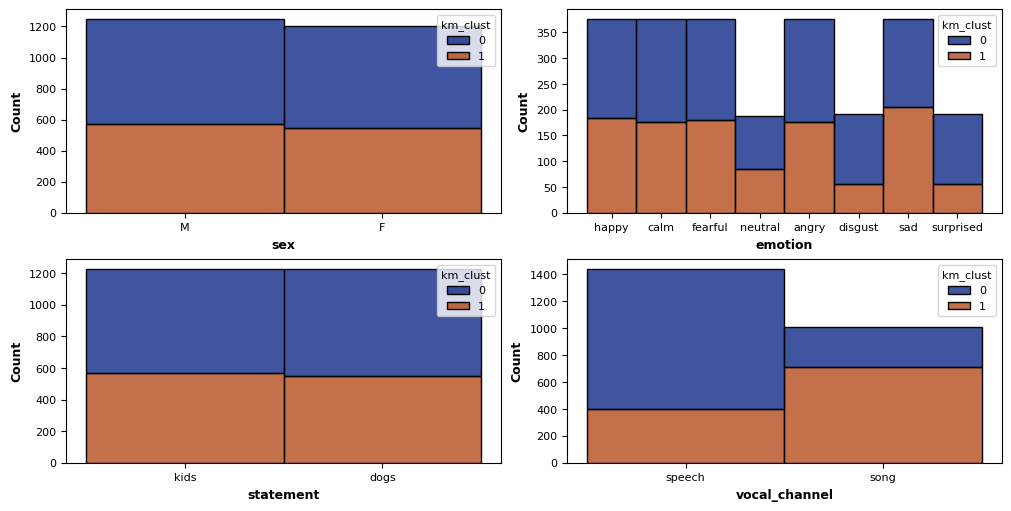

In [432]:
fig, axs = plt.subplots(nrows=2, ncols=2, constrained_layout=True)
i=0
j=0
for col in ['sex', 'emotion', 'statement', 'vocal_channel']:
        if j==2:
            j=0
            i=i+1
        sns.histplot(df_ex, x=col, hue='km_clust', multiple="stack" ,palette='dark', ax=axs[i][j])
        j=j+1
plt.show()

## Features clustering on spectral timeseries

In [343]:
import scipy.stats as stats
from sklearn.cluster import KMeans
from scipy.signal import find_peaks

In [344]:
X = traces['spectral_centroid']


In [345]:
def calculate_features(values):
    peaks = find_peaks(values, distance=3, prominence=[0.20,10])
    features = {
        'peaks':len(peaks[0]),
        'min': np.min(values),
        'max': np.max(values),
        'avg': np.mean(values),
        '10p': np.percentile(values, 10),
        '25p': np.percentile(values, 25),
    }

    return features

In [346]:
F = [list(calculate_features(x).values()) for x in X]

In [347]:
from sklearn.metrics import silhouette_score
sil_scores = []
for n in range(2, 20):
    km = KMeans(n_clusters=n)
    km.fit(F)
    sil_scores.append(silhouette_score(F, km.predict(F)))
    

C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

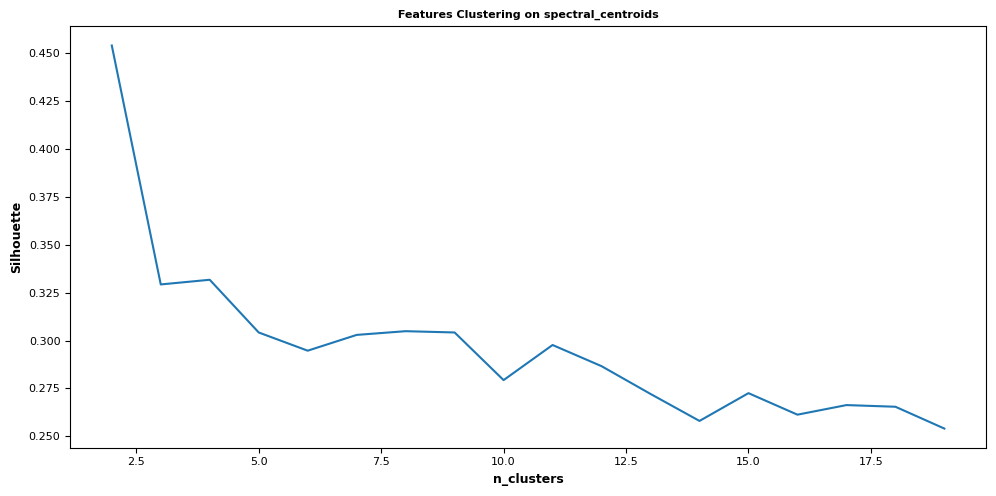

In [348]:
plt.plot(range(2, 20),sil_scores)
plt.title(' Features Clustering on spectral_centroids ')
plt.ylabel('Silhouette')
plt.xlabel('n_clusters')
plt.show()

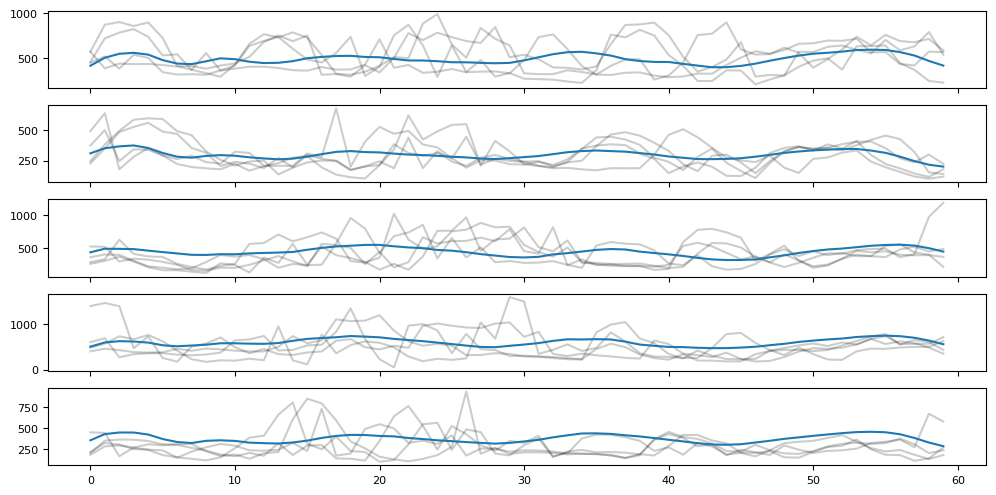

In [382]:
n_clusters = 5


km = KMeans(n_clusters=n_clusters, n_init=10, max_iter=100)
km.fit(F)

fig, axes = plt.subplots(n_clusters,sharex=True)

for clus in range(n_clusters):
    cluster_elements = X[km.labels_ == clus]
    for i in range(4):
        axes[clus].plot(cluster_elements[i], alpha=0.2, color="k")
    
    axes[clus].plot(np.mean(X[np.where(km.labels_ == clus)[0]], axis=0))
    
plt.show()

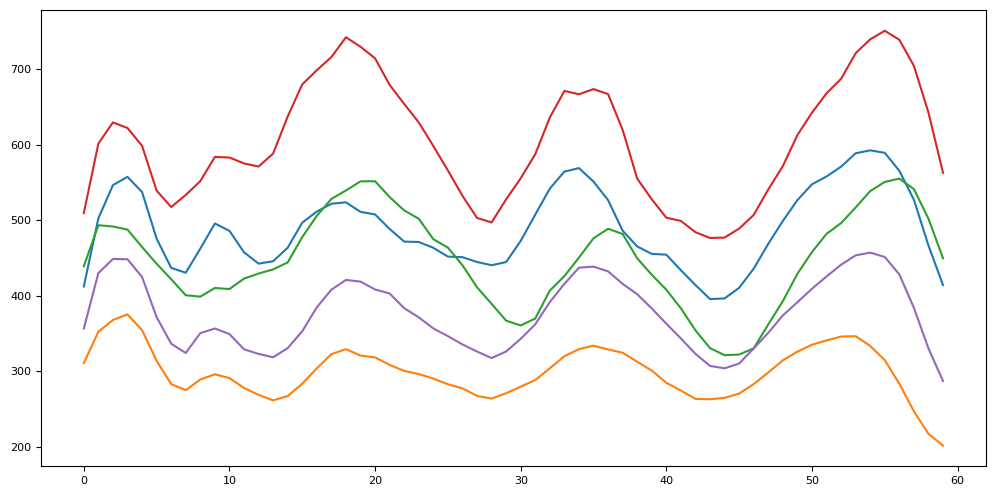

In [383]:
for i in range(n_clusters):
    plt.plot(np.mean(X[np.where(km.labels_ == i)[0]], axis=0))
plt.show()

In [384]:
df_ex = df.copy()
df_ex['km_clust'] = km.labels_

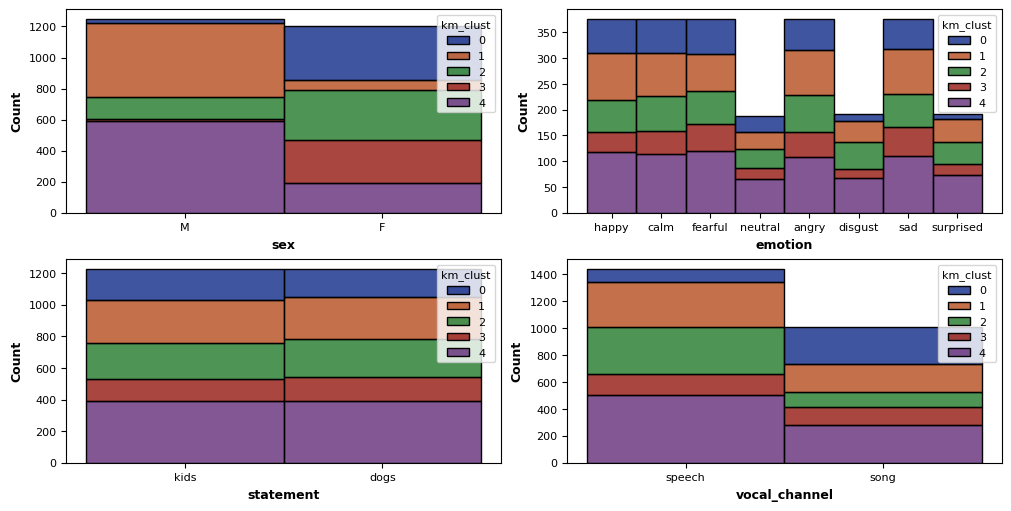

In [385]:
fig, axs = plt.subplots(nrows=2, ncols=2, constrained_layout=True)
i=0
j=0
for col in ['sex', 'emotion', 'statement', 'vocal_channel']:
        if j==2:
            j=0
            i=i+1
        sns.histplot(df_ex, x=col, hue='km_clust', multiple="stack" ,palette='dark', ax=axs[i][j])
        j=j+1
plt.show()

# Clustering visualization

## PCA

In [386]:
from sklearn.decomposition import PCA

In [433]:
pca = PCA(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)

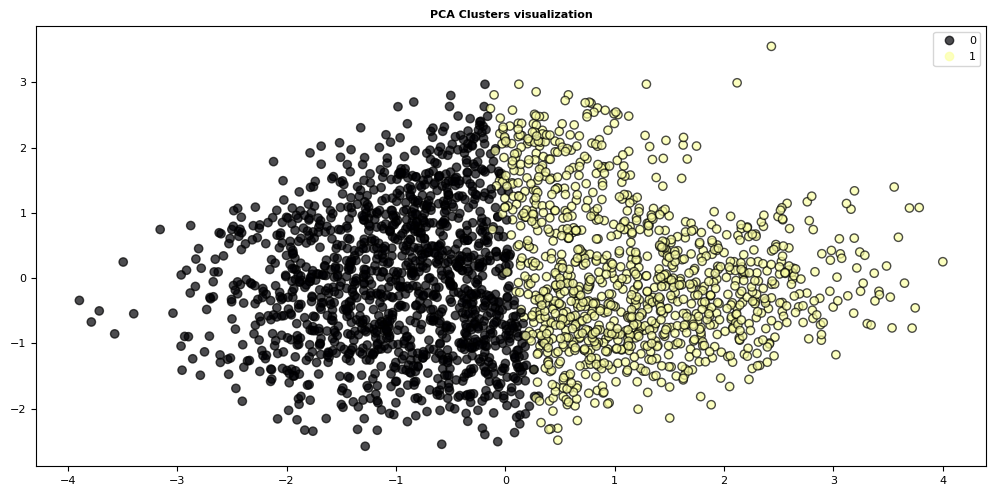

In [434]:
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=km.labels_, cmap='inferno', edgecolor='k'
             , alpha=0.7)
plt.legend(handles=scatter.legend_elements()[0], labels=list(np.unique(km.labels_)))
plt.title('PCA Clusters visualization')
plt.show()

## MultiDim Scaling

In [422]:
from sklearn.manifold import Isomap

In [435]:
iso = Isomap(n_components=2)
X_iso = iso.fit_transform(X)

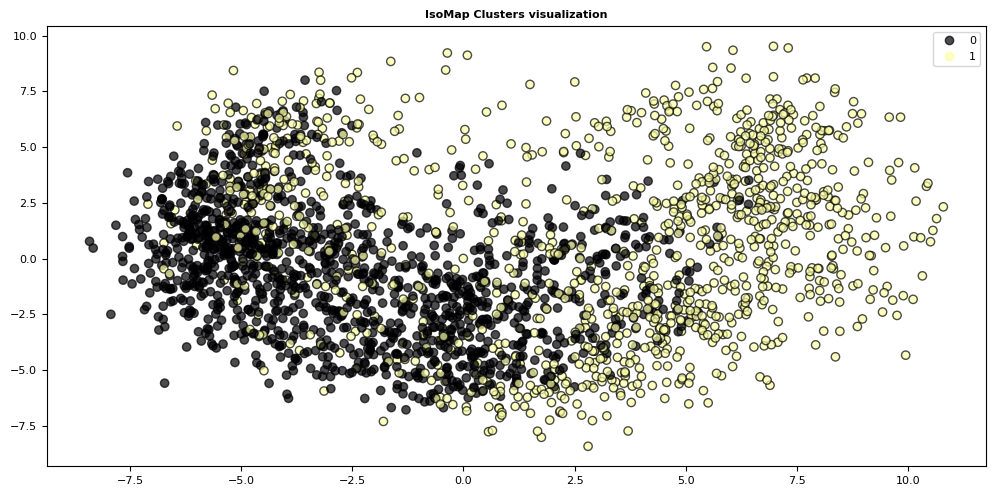

In [436]:
scatter = plt.scatter(X_iso[:, 0], X_iso[:, 1], c=km.labels_, cmap='inferno', edgecolor='k',alpha=0.7)
plt.legend(handles=scatter.legend_elements()[0], labels=list(np.unique(km.labels_)))
plt.title('IsoMap Clusters visualization')
plt.show()